In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [2]:
with open('data/train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    print("This is the data after initial read in:", data.shape, sep=" ")
    Xtraindata = np.transpose(data.reshape((size, nrows*ncols)))

with open('data/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytrainlabels = data.reshape((size,)) # (Optional)

with open('data/t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    Xtestdata = np.transpose(data.reshape((size, nrows*ncols)))

with open('data/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytestlabels = data.reshape((size,)) # (Optional)
        

    
traindata_imgs =  np.transpose(Xtraindata).reshape((60000,28,28))    
print(Xtraindata.shape)
print(ytrainlabels.shape)
print(Xtestdata.shape)
print(ytestlabels.shape)

This is the data after initial read in: (47040000,)
(784, 60000)
(60000,)
(784, 10000)
(10000,)


In [3]:
pca_16 = PCA(n_components=16)

Xtraindata_pca_16 = pca_16.fit_transform(Xtraindata.T)

print(pca_16.components_.shape)

(16, 784)


In [4]:
def plot_digits(XX: np.array, N: int, title: str, cmap: str = "Greys") -> None:
    """
    Plot the first N*N digits in the array XX
    
    :param XX: (d, N*N) array of digits
    :param N: number of digits to plot in each dimension
    :param title: title of the plot
    :param cmap: colormap

    :return: None
    """
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[:,(N)*i+j].reshape((28, 28)), cmap=cmap)
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

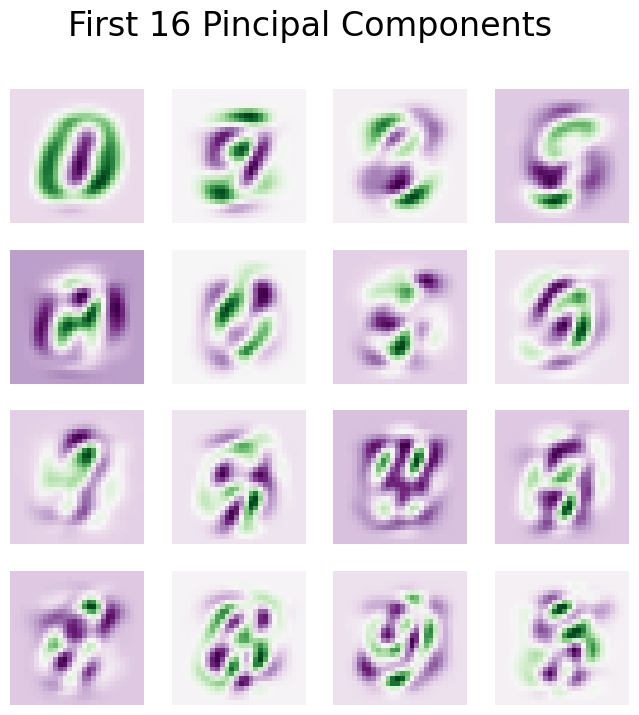

In [5]:
plot_digits(pca_16.components_.T, 4, "First 16 Pincipal Components", cmap="PRGn")

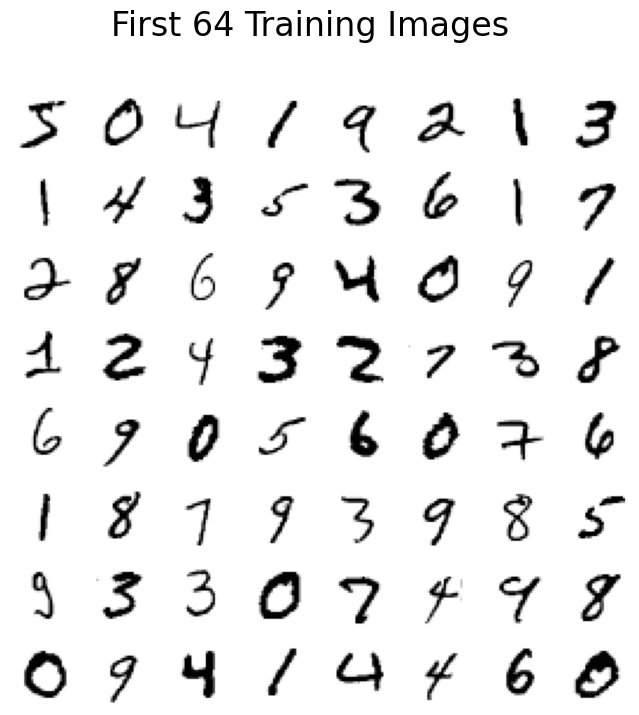

In [6]:
plot_digits(Xtraindata, 8, "First 64 Training Images")

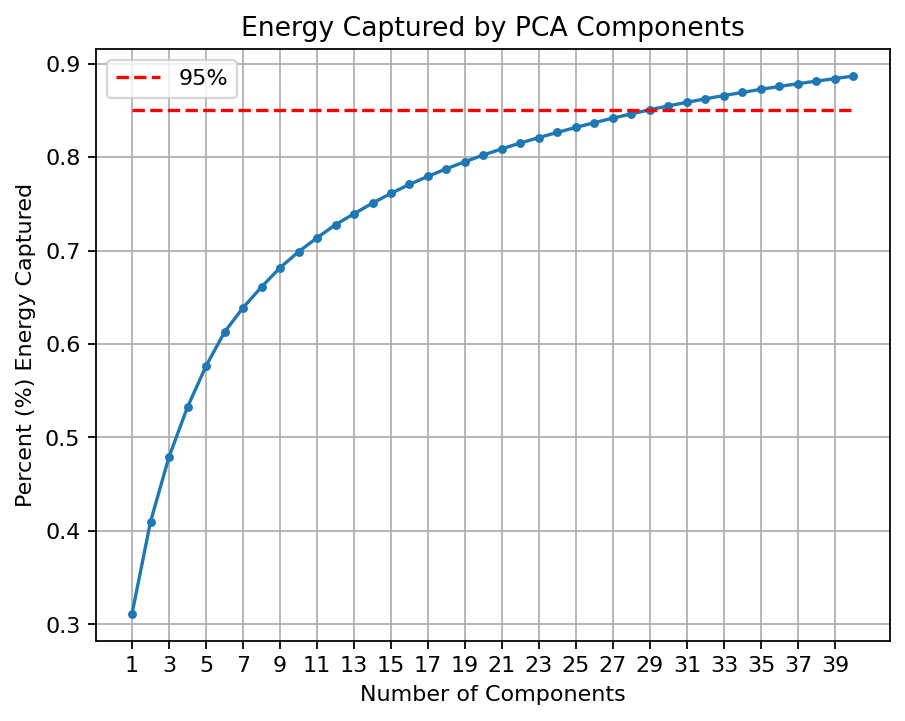

In [7]:
pca_model_for_task_2 = PCA()
pca_model_for_task_2.fit(Xtraindata.T)

energy_by_components = np.sqrt(np.cumsum(pca_model_for_task_2.singular_values_**2))/np.sqrt(np.sum(pca_model_for_task_2.singular_values_**2))

num_to_plot = 40

fig = plt.figure(dpi=160)
ax = fig.add_subplot(111)
ax.plot(np.arange(1,115)[:num_to_plot], energy_by_components[:num_to_plot], 'o-', markersize=3)
ax.grid()
ax.set_title("Energy Captured by PCA Components")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Percent (%) Energy Captured")
ax.hlines(0.85, 1, num_to_plot, linestyles='dashed', colors='r', label='95%')

# ax.set_ylim(0, 1)
ax.set_xticks(np.arange(1, num_to_plot, 2))
plt.legend()
# plt.savefig("visualizations/energy_by_components.png") # TODO Update path
plt.show()


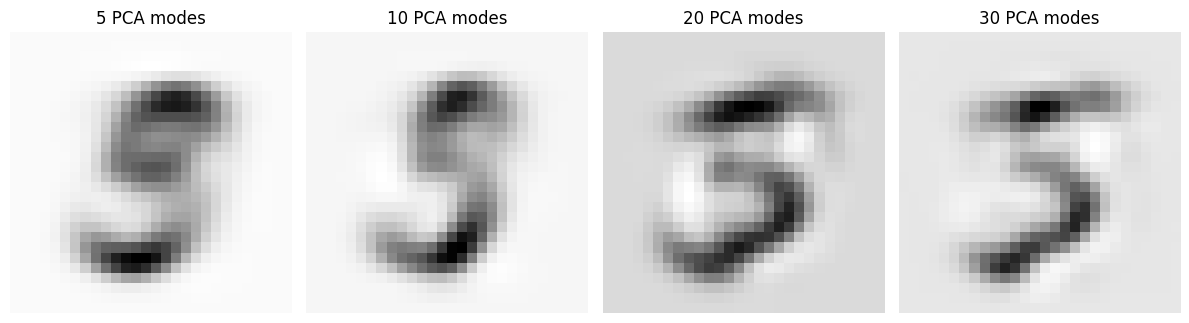

In [8]:
# TODO: Figure out ho to inspect several approximated digit images reconstructed from 𝑘 truncated
#   PC modes and plot them to make sure that the image reconstruction using truncated modes is reasonable.

plot_this_digit = 0

pca_5 = PCA(n_components=5)
pca_10 = PCA(n_components=10)
pca_20 = PCA(n_components=20)
pca_30 = PCA(n_components=30)

approx_5 = pca_5.inverse_transform(pca_5.fit_transform(Xtraindata.T))
approx_10 = pca_10.inverse_transform(pca_10.fit_transform(Xtraindata.T))
approx_20 = pca_20.inverse_transform(pca_20.fit_transform(Xtraindata.T))
approx_30 = pca_30.inverse_transform(pca_30.fit_transform(Xtraindata.T))

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.imshow(approx_5[plot_this_digit].reshape((28,28)), cmap="Greys")
ax2.imshow(approx_10[plot_this_digit].reshape((28,28)), cmap="Greys")
ax3.imshow(approx_20[plot_this_digit].reshape((28,28)), cmap="Greys")
ax4.imshow(approx_30[plot_this_digit].reshape((28,28)), cmap="Greys")

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

ax1.set_title("5 PCA modes")
ax2.set_title("10 PCA modes")
ax3.set_title("20 PCA modes")
ax4.set_title("30 PCA modes")

plt.tight_layout()
plt.show()